In [1]:
part1_single_objects = "COTSDataset/Part 1 - Single Objects"
part2_multiple_objects = "COTSDataset/Part 2 - Multiple Objects"
part3_complex_background = "COTSDataset/Part 3 - Complex Background"

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import SaRa.saraRC1 as sara

In [3]:
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:
img_path = os.path.join(part2_multiple_objects, "academic_book_no", "1_colour.jpeg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_7_mask.png")
mask = cv2.imread(mask_path)

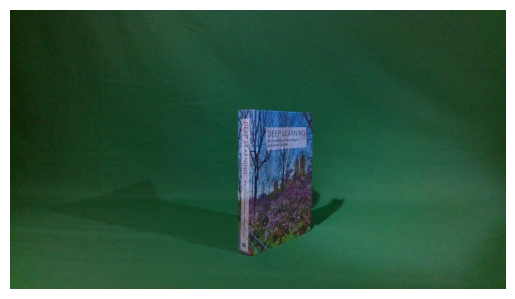

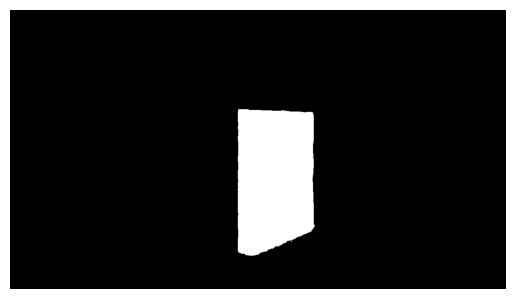

In [5]:
plot_img(img)
plot_img(mask)

In [6]:
def iou(image, mask):
    intersection = np.logical_and(image, mask)
    union = np.logical_or(image, mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def f1_score(image, mask):
    intersection = np.logical_and(image, mask)
    precision = np.sum(intersection) / np.sum(image)
    recall = np.sum(intersection) / np.sum(mask)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [7]:
generator = 'itti'
GRID_SIZE = 8 #100
sara.reset()
bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
sara_info = sara.return_sara(bgr_img, GRID_SIZE, generator)

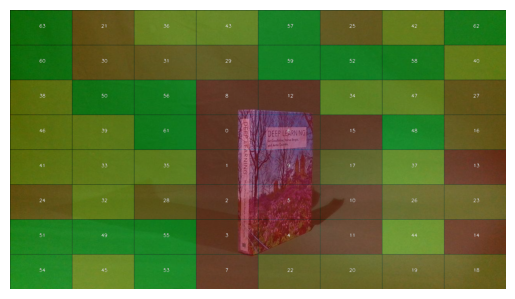

In [8]:
heatmap = cv2.cvtColor(sara_info[0], cv2.COLOR_BGR2RGB)
plot_img(heatmap)

In [9]:
# Creating a mask from the heatmap
# Rank, score, entropy, centre-bias, depth, index, quartile

# Changing info into a dictionary
sara_dict = {}
for info in sara_info[1]:
    rank, score, entropy, centre_bias, depth, index, quartile = info
    sara_dict[rank] = {}
    sara_dict[rank]['score'] = score
    sara_dict[rank]['entropy'] = entropy
    sara_dict[rank]['centre_bias'] = centre_bias
    sara_dict[rank]['depth'] = depth
    sara_dict[rank]['index'] = index
    sara_dict[rank]['quartile'] = quartile
    
# Sorting the dictionary by the scores key in the nested dictionary
sorted_sara_dict = {}
for key in sorted(sara_dict, key=lambda k: sara_dict[k]['score'], reverse=True):
    sorted_sara_dict[key] = sara_dict[key]

sorted_sara_dict

{27: {'score': 7.646999082167113e+72,
  'entropy': 7.646999082167113e+72,
  'centre_bias': 0.9460576467255959,
  'depth': 1,
  'index': 0,
  'quartile': 1},
 35: {'score': 3.515658920136871e+71,
  'entropy': 3.515658920136871e+71,
  'centre_bias': 0.9726549474122855,
  'depth': 1,
  'index': 1,
  'quartile': 1},
 43: {'score': 3.700007598037868e+69,
  'entropy': 3.700007598037868e+69,
  'centre_bias': 0.9460576467255959,
  'depth': 1,
  'index': 2,
  'quartile': 1},
 51: {'score': 8.98520233790712e+57,
  'entropy': 8.98520233790712e+57,
  'centre_bias': 0.8705505632961241,
  'depth': 1,
  'index': 3,
  'quartile': 1},
 52: {'score': 7.205144766295556e+51,
  'entropy': 7.205144766295556e+51,
  'centre_bias': 0.8950250709279725,
  'depth': 1,
  'index': 4,
  'quartile': 1},
 44: {'score': 1.0113149865080375e+46,
  'entropy': 1.0113149865080375e+46,
  'centre_bias': 0.9726549474122855,
  'depth': 1,
  'index': 5,
  'quartile': 1},
 28: {'score': 1.390792808339948e+43,
  'entropy': 1.39079

In [10]:
def generate_segments(img, seg_count) -> list:
    '''
    Given an image img and the desired number of segments seg_count, this 
    function divides the image into segments and returns a list of segments.
    '''

    segments = {}
    segment_count = seg_count
    index = 0

    w_interval = int(img.shape[1] / segment_count)
    h_interval = int(img.shape[0] / segment_count)

    for i in range(segment_count):
        for j in range(segment_count):        
            
            coord_tup = (int(w_interval * j), int(h_interval * i),
                         int(w_interval * (j + 1)), int(h_interval * (i + 1)))
            segments[index] = coord_tup
            index += 1

    return segments

In [11]:
index_info = generate_segments(img, GRID_SIZE)

for rank in sorted_sara_dict:
    sorted_sara_dict[rank]['segment'] = index_info[rank]

In [12]:
# Taking the top 20 ranks and using them to create a mask
most_imp_ranks = np.zeros_like(img)

max_rank = int(GRID_SIZE*GRID_SIZE * 0.2)
count = 0
for rank in sorted_sara_dict.keys():
    if count <= max_rank:
        # Creating a mask based on the index and quartile
        index = rank
        
        coords = sorted_sara_dict[rank]['segment']
        x1, y1, x2, y2 = coords

        most_imp_ranks[y1:y2, x1:x2] = 255
    else:
        break
    count += 1

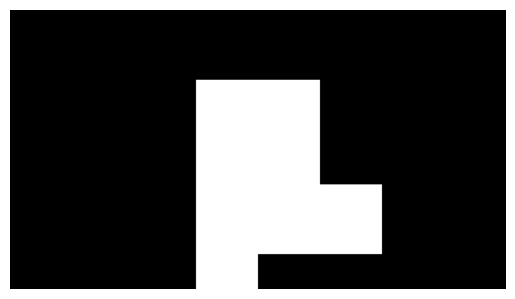

In [13]:
plot_img(most_imp_ranks)

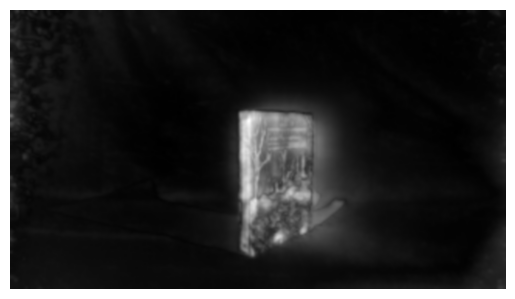

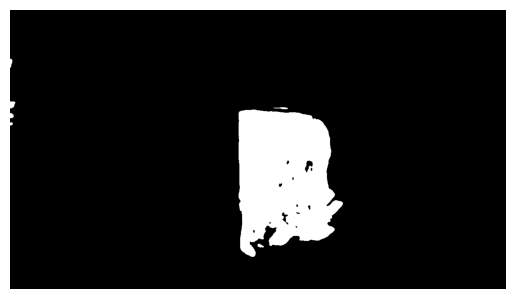

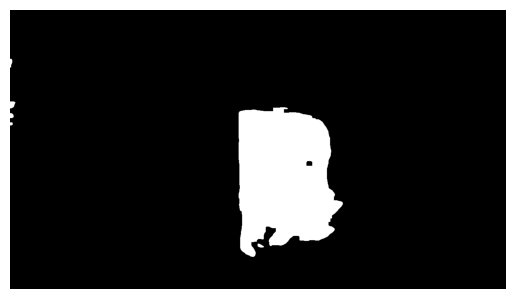

In [14]:
saliency_map = sara.return_saliency(img.copy(), generator=generator)
saliency_map_rgb = cv2.cvtColor(saliency_map, cv2.COLOR_BGR2RGB)
saliency_map_gray = cv2.cvtColor(saliency_map_rgb, cv2.COLOR_RGB2GRAY)
plot_img(saliency_map_rgb)


# Perform OTSU thresholding on the grayscale saliency map
ret, thresh = cv2.threshold(saliency_map_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_img(thresh)

# Performing morphological operations on the thresholded image
kernel = np.ones((5,5), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=2)
erosion = cv2.erode(dilated, kernel, iterations=2)
plot_img(erosion)


In [15]:
print("Itti saliency map")
iou_score = iou(saliency_map_rgb, mask)
print("IOU score: ", iou_score)
weighted_iou_score = f1_score(saliency_map_rgb, mask)
print("F1 Score: ", weighted_iou_score)
print()
print("Morphology on saliency map")
morphed_img = cv2.cvtColor(erosion, cv2.COLOR_GRAY2RGB)
iou_score = iou(morphed_img, mask)
print("IOU score: ", iou_score)
weighted_iou_score = f1_score(morphed_img, mask)
print("F1 Score: ", weighted_iou_score)

Itti saliency map
IOU score:  0.07372867188738193
F1 Score:  0.0036876787637016087

Morphology on saliency map
IOU score:  0.7625849029336673
F1 Score:  0.0033933446566289647


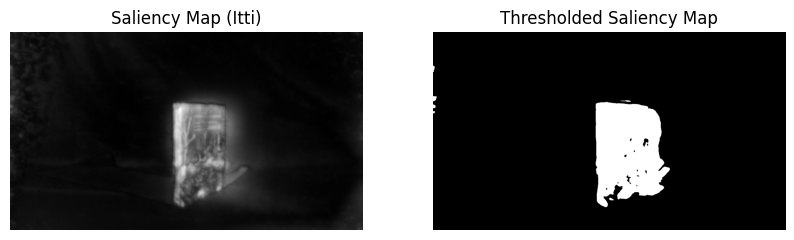

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(saliency_map_rgb)
ax[0].axis('off')
ax[0].set_title("Saliency Map (Itti)")
ax[1].imshow(thresh, cmap='gray')
ax[1].axis('off')
ax[1].set_title("Thresholded Saliency Map")
plt.show()

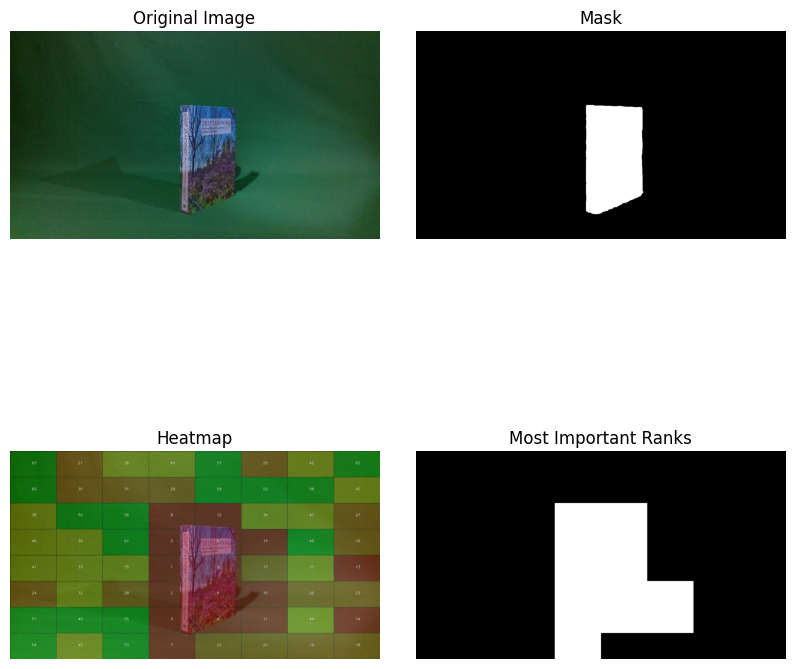

In [17]:
# Plotting in a 2 by 2 grid, the original img, mask, heatmap and the most important ranks
# Adjusting padding between the rows and columns
plt.rcParams['figure.subplot.wspace'] = 0.1

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(img)
ax[0, 0].axis('off')
ax[0, 0].set_title('Original Image')

ax[0, 1].imshow(mask)
ax[0, 1].axis('off')
ax[0, 1].set_title('Mask')

ax[1, 0].imshow(heatmap)
ax[1, 0].axis('off')
ax[1, 0].set_title('Heatmap')

ax[1, 1].imshow(most_imp_ranks)
ax[1, 1].axis('off')
ax[1, 1].set_title('Most Important Ranks')

plt.show()

# GradCam

In [18]:
from torchvision import models
import numpy as np
import cv2
import PIL

In [19]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

In [20]:

model = models.resnet50(pretrained=True)
model.eval()

c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

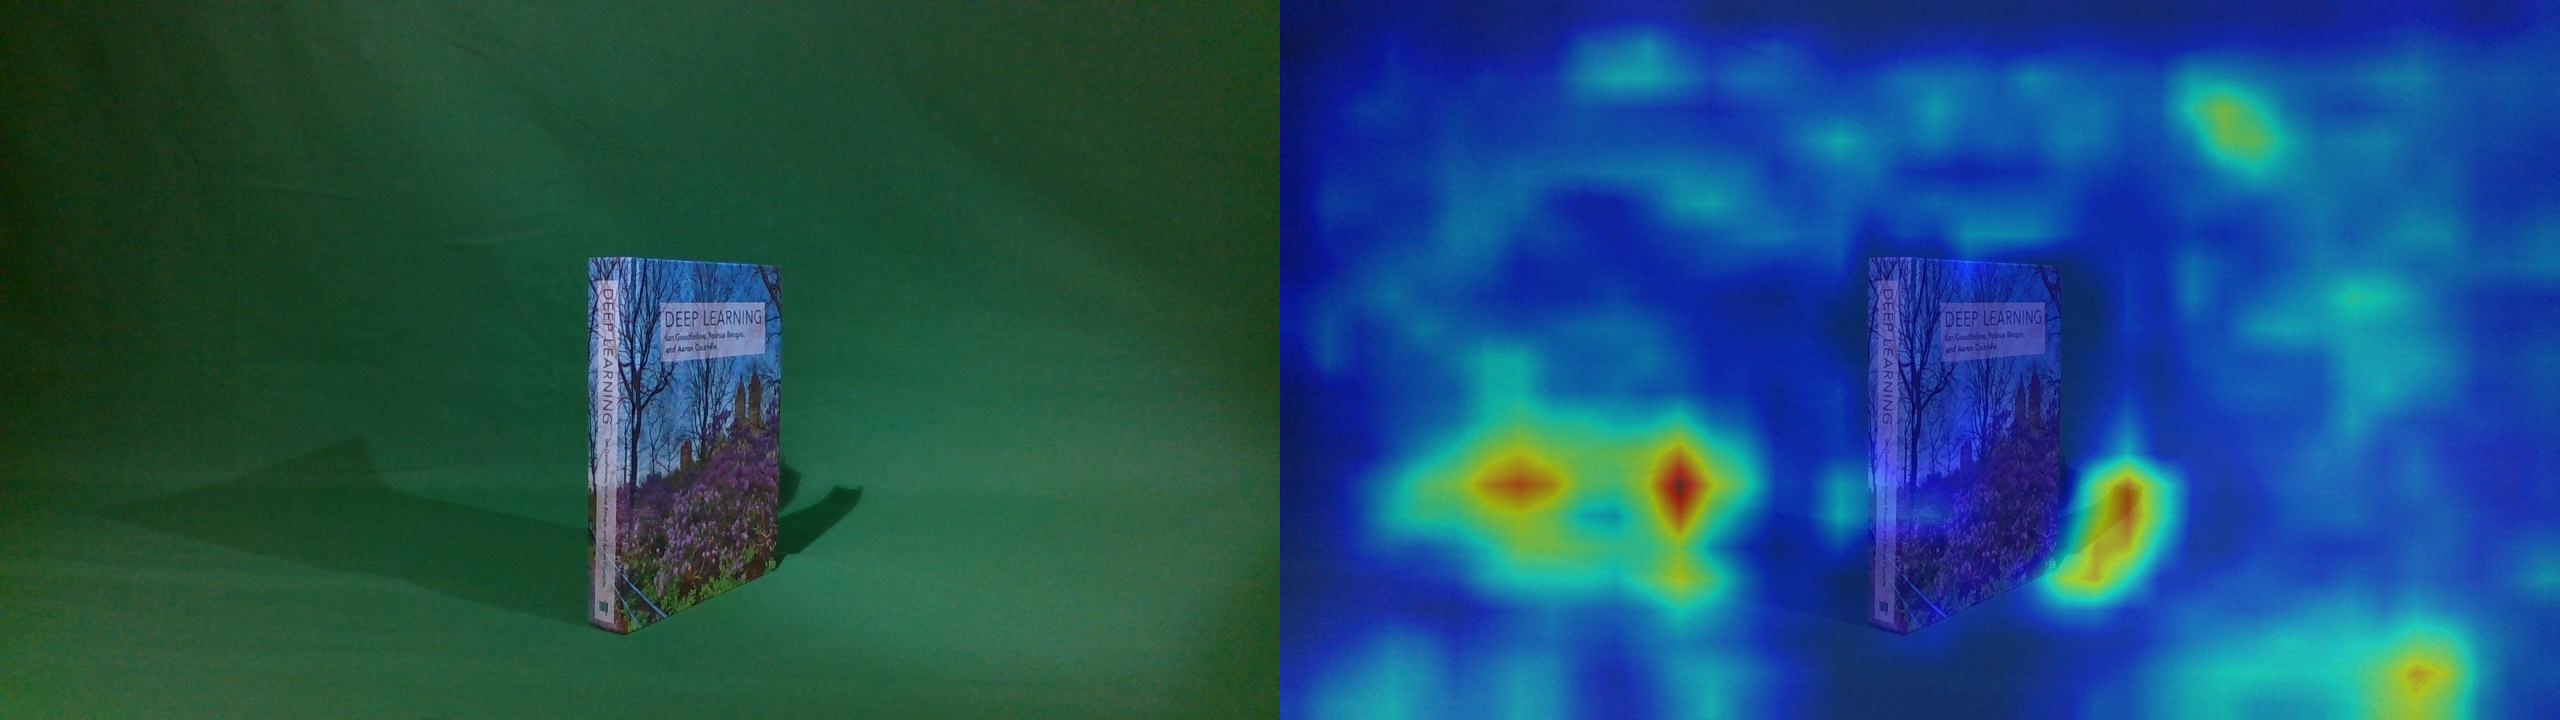

In [21]:

# fix target class label (of the Imagenet class of interest!)
# 1: goldfish, 250: Siberian Husky, 947: mushroom

targets = [ClassifierOutputTarget(1)] 

# fix the target layer (after which we'd like to generate the CAM)
target_layers = [model.layer4]

# instantiate the model
cam = GradCAM(model=model, target_layers=target_layers)
# cam = GradCAMPlusPlus(model=model, target_layers=target_layers) # use this for Grad-CAM++

# Preprocess input image, get the input image tensor

new_img = img.copy()
new_img = np.float32(new_img) / 255
input_tensor = preprocess_image(new_img)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
cam_image = show_cam_on_image(new_img, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])

# display the original image & the associated CAM
images = np.hstack((np.uint8(255*new_img), cam_image))
PIL.Image.fromarray(images)

In [22]:
# !pip install gymnasium

def calculate_reward(image, mask):
    pass

In [23]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class MaskGenerationEnv(gym.Env):
    def __init__(self, image, image_shape, max_iterations):
        super(MaskGenerationEnv, self).__init__()

        # Define the state space
        self.image = image
        self.image_shape = image_shape
        self.observation_space = spaces.Box(low=0, high=255, shape=image_shape, dtype=np.uint8)

        # Define the action space (each pixel can be darkened or lightened)
        self.action_space = spaces.Discrete(image_shape[0] * image_shape[1] * 2)

        # Initialize current state (mask)
        self.current_mask = np.zeros(image_shape, dtype=np.uint8)

        # Maximum number of iterations
        self.max_iterations = max_iterations
        self.current_iteration = 0
        self.cumulative_reward = 0

    def step(self, action):
        # Translate the action index to the pixel coordinates and darkening/lightening
        pixel_x, pixel_y, action_type = action

        # Apply the selected action (0 for darken, 1 for lighten) to the specified pixel
        if action_type == 0:
            self.current_mask[pixel_x, pixel_y] = np.maximum(self.current_mask[pixel_x, pixel_y] - 255, 0)
        elif action_type == 1:
            self.current_mask[pixel_x, pixel_y] = np.minimum(self.current_mask[pixel_x, pixel_y] + 255, 255)

        # Calculate reward (e.g., based on similarity to ground truth)
        reward = calculate_reward(self.image, self.current_mask)

        # Check if the episode should terminate
        terminated = truncated = self.current_iteration >= self.max_iterations

        # Return the next state, reward, whether the episode is done, and additional info
        return self.current_mask, reward, terminated, truncated, {"info" : "Additional info"}

    def reset(self):
        # Reset the environment to the initial state
        self.current_mask = np.zeros(self.image_shape, dtype=np.uint8)

        self.current_iteration = 0
        self.cumulative_reward = 0
        
        return self.current_mask

    def render(self, mode='mask'):
        if(mode == 'mask'):
            plt.imshow(self.current_mask, cmap='gray')
            plt.axis('off')
            plt.show()
        elif(mode == 'image'):
            plt.imshow(self.image, cmap='gray')
            plt.axis('off')
            plt.show()
        else:
            pass

In [24]:
# Idea try to generate multiple saliency maps and then over training time, try to sample from them all randomly to learn the mask